# Import Utility Script & Libraries

In [1]:
import gc
import os
import random
import re
import warnings
from collections import Counter

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import plotly.express as px
import seaborn as sns
from gensim.models import Word2Vec
from scipy.stats import kurtosis, skew
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.autonotebook import tqdm

/home/rohit/Desktop/kaggle/virtualenvs/writing_quality/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Set Global Configuration Options

In [2]:
class CONFIG:
    """
    > General Options
    """

    # global seed
    seed = 42
    # the number of samples to use for testing purposes
    # if None, we use the full dataset
    samples_testing = None  # None
    # max rows to display for pandas dataframes
    display_max_rows = 100
    # name of the response variate we are trying to predict
    response_variate = "score"

    """
    > Preprocessing Options
    """
    # number of folds to split the data for CV
    num_folds = 5

    """
    > Modelling Options
    """
    # whether to use optuna tuning or not
    # if False, then we load in pretuned weights for the LGBM models
    use_optuna_tuning = True
    # size of the test set for optuna tuning
    # if use_optuna_tuning=True
    test_size_optuna = 0.2
    # number of estimators to use for the boosting model
    num_estimators = 5000
    # number of trials to use for optuna tuning
    # if use_optuna_tuning=True
    num_trials_optuna = 80
    # number of trials to use for early stopping
    num_trials_early_stopping = 250

    """
    > Post-Modelling Options
    """
    # number of most important features to display
    # for the feature importances plot
    num_features_to_display = 50

    # Data Paths
    base_dir_path = f"data/"

    train_logs = f"{base_dir_path}train_logs.csv"
    train_scores = f"{base_dir_path}train_scores.csv"
    test_logs = f"{base_dir_path}test_logs.csv"

In [3]:
tqdm.pandas()

sns.set_style("whitegrid")

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", CONFIG.display_max_rows)
warnings.simplefilter("ignore")

random.seed(CONFIG.seed)

# Load Data

In [5]:
train_logs = pd.read_csv(CONFIG.train_logs)
train_scores = pd.read_csv(CONFIG.train_scores)
test_logs = pd.read_csv(CONFIG.test_logs)

In [6]:
df_train = train_logs.merge(train_scores, on="id", suffixes=(None, None))

## Subsample Data (If Specified)

In [7]:
# if CONFIG.samples_testing is not None:
#     ids = list(train_logs["id"].unique())
#     sample_ids = random.sample(ids, CONFIG.samples_testing)
#     train_logs = train_logs[train_logs["id"].isin(sample_ids)]

In [8]:
train_logs.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1


In [9]:
train_logs.shape

(8405898, 11)

In [10]:
df_train.shape

(8405898, 12)

In [11]:
df_train.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count,score
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0,3.5
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0,3.5
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0,3.5
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1,3.5
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1,3.5


In [12]:
df_train.score.value_counts()

score
4.0    1780944
4.5    1682310
3.5    1465763
3.0     852729
5.0     846264
5.5     704602
2.5     462098
6.0     209975
2.0     183809
1.5     144713
1.0      64833
0.5       7858
Name: count, dtype: int64

In [13]:
df_train.activity.value_counts()

activity
Input                                     6726796
Remove/Cut                                 970158
Nonproduction                              703851
Replace                                      4448
Paste                                         599
Move From [1306, 1371] To [1061, 1126]          2
Move From [13, 65] To [9, 61]                   1
Move From [274, 314] To [299, 339]              1
Move From [624, 625] To [845, 846]              1
Move From [1861, 2063] To [1766, 1968]          1
Move From [1766, 1968] To [1861, 2063]          1
Move From [2091, 2179] To [252, 340]            1
Move From [923, 1077] To [340, 494]             1
Move From [0, 1] To [590, 591]                  1
Move From [999, 1000] To [1000, 1001]           1
Move From [0, 75] To [1, 76]                    1
Move From [1651, 1769] To [1565, 1683]          1
Move From [61, 136] To [0, 75]                  1
Move From [623, 632] To [624, 633]              1
Move From [75, 134] To [304, 363]        

In [14]:
df_train.text_change.value_counts()

text_change
q                                                                                                                                                               6128208
                                                                                                                                                                1376829
NoChange                                                                                                                                                         703851
.                                                                                                                                                                 67797
,                                                                                                                                                                 54797
                                                                                                                                                    

In [15]:
df_train.down_event.value_counts().reset_index().rename(
    columns={"index": "value", 0: "count"}
)

,down_event,count
0,q,5365319
1,Space,1207128
2,Backspace,964089
3,Shift,334227
4,ArrowRight,121338
...,...,...
126,F10,1
127,Cancel,1
128,S,1
129,T,1


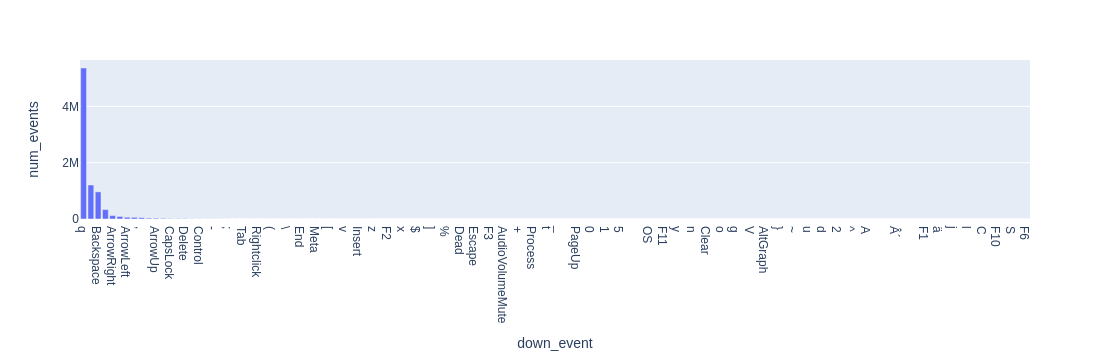

In [32]:
fig = px.bar(
    df_train.down_event.value_counts()
    .reset_index()
    .rename(columns={"count": "num_events"}),
    x="down_event",
    y="num_events",
)
fig.show()

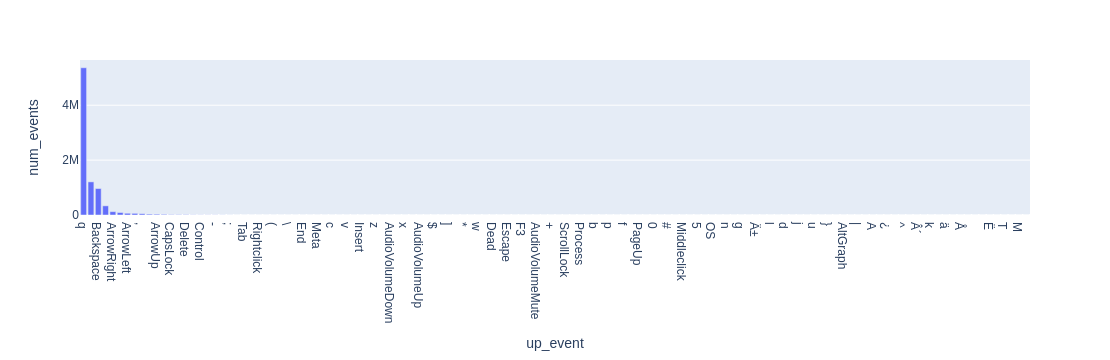

In [31]:
fig = px.bar(
    df_train.up_event.value_counts()
    .reset_index()
    .rename(columns={"count": "num_events"}),
    x="up_event",
    y="num_events",
)
fig.show()

In [28]:
down_event_cnt_df = (
    df_train.down_event.value_counts()
    .reset_index()
    .rename(columns={"count": "num_events"})
)

In [33]:
down_event_cnt_df

,down_event,num_events
0,q,5365319
1,Space,1207128
2,Backspace,964089
3,Shift,334227
4,ArrowRight,121338
...,...,...
126,F10,1
127,Cancel,1
128,S,1
129,T,1


In [34]:
down_event_cnt_df.num_events.describe()

count    1.310000e+02
mean     6.416716e+04
std      4.865984e+05
min      1.000000e+00
25%      4.000000e+00
50%      2.100000e+01
75%      4.725000e+02
max      5.365319e+06
Name: num_events, dtype: float64

In [41]:
down_event_cats = down_event_cnt_df[
    down_event_cnt_df.num_events >= 15
].down_event.values.tolist()

In [42]:
down_event_cats

['q',
 'Space',
 'Backspace',
 'Shift',
 'ArrowRight',
 'Leftclick',
 'ArrowLeft',
 '.',
 ',',
 'ArrowDown',
 'ArrowUp',
 'Enter',
 'CapsLock',
 "'",
 'Delete',
 'Unidentified',
 'Control',
 '"',
 '-',
 '?',
 ';',
 '=',
 'Tab',
 '/',
 'Rightclick',
 ':',
 '(',
 ')',
 '\\',
 'ContextMenu',
 'End',
 '!',
 'Meta',
 'Alt',
 '[',
 'c',
 'v',
 'NumLock',
 'Insert',
 'Home',
 'z',
 'AudioVolumeDown',
 'F2',
 'a',
 'x',
 'AudioVolumeUp',
 '$',
 '>',
 ']',
 '*',
 '%',
 '&',
 'Dead',
 's',
 'Escape',
 'ModeChange',
 'F3',
 '<',
 'AudioVolumeMute',
 'F15',
 '+',
 'ScrollLock',
 'Process',
 'PageDown',
 't',
 'i',
 '_',
 '{',
 'PageUp',
 '`',
 '0',
 '#',
 '1',
 'Middleclick',
 '5',
 'F12']

# Feature Engineering

In [43]:
class Preprocessor:
    def __init__(self, seed):
        self.seed = seed

        self.activities = ["Input", "Remove/Cut", "Nonproduction", "Replace", "Paste"]
        # self.events = [
        #     "q",
        #     "Space",
        #     "Backspace",
        #     "Shift",
        #     "ArrowRight",
        #     "Leftclick",
        #     "ArrowLeft",
        #     ".",
        #     ",",
        #     "ArrowDown",
        #     "ArrowUp",
        #     "Enter",
        #     "CapsLock",
        #     "'",
        #     "Delete",
        #     "Unidentified",
        # ]
        self.events = [
            "q",
            "Space",
            "Backspace",
            "Shift",
            "ArrowRight",
            "Leftclick",
            "ArrowLeft",
            ".",
            ",",
            "ArrowDown",
            "ArrowUp",
            "Enter",
            "CapsLock",
            "'",
            "Delete",
            "Unidentified",
            "Control",
            '"',
            "-",
            "?",
            ";",
            "=",
            "Tab",
            "/",
            "Rightclick",
            ":",
            "(",
            ")",
            "\\",
            "ContextMenu",
            "End",
            "!",
            "Meta",
            "Alt",
            "[",
            "c",
            "v",
            "NumLock",
            "Insert",
            "Home",
            "z",
            "AudioVolumeDown",
            "F2",
            "a",
            "x",
            "AudioVolumeUp",
            "$",
            ">",
            "]",
            "*",
            "%",
            "&",
            "Dead",
            "s",
            "Escape",
            "ModeChange",
            "F3",
            "<",
            "AudioVolumeMute",
            "F15",
            "+",
            "ScrollLock",
            "Process",
            "PageDown",
            "t",
            "i",
            "_",
            "{",
            "PageUp",
            "`",
            "0",
            "#",
            "1",
            "Middleclick",
            "5",
            "F12",
            "Unidentified",
        ]
        self.text_changes = [
            "q",
            " ",
            "NoChange",
            ".",
            ",",
            "\n",
            "'",
            '"',
            "-",
            "?",
            ";",
            "=",
            "/",
            "\\",
            ":",
        ]
        self.punctuations = [
            '"',
            ".",
            ",",
            "'",
            "-",
            ";",
            ":",
            "?",
            "!",
            "<",
            ">",
            "/",
            "@",
            "#",
            "$",
            "%",
            "^",
            "&",
            "*",
            "(",
            ")",
            "_",
            "+",
        ]
        self.gaps = [1, 2, 3, 5, 10, 20, 50]

    #         self.gaps = [1, 2]

    def activity_counts(self, df):
        tmp_df = df.groupby("id").agg({"activity": list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df["activity"].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.activities:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f"activity_{i}_count" for i in range(len(ret.columns))]
        ret.columns = cols
        return ret

    def event_counts(self, df, colname):
        tmp_df = df.groupby("id").agg({colname: list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df[colname].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.events:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
                else:
                    di["Unidentified"] += v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f"{colname}_{i}_count" for i in range(len(ret.columns))]
        ret.columns = cols
        return ret

    def text_change_counts(self, df):
        tmp_df = df.groupby("id").agg({"text_change": list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df["text_change"].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.text_changes:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f"text_change_{i}_count" for i in range(len(ret.columns))]
        ret.columns = cols
        return ret

    def match_punctuations(self, df):
        tmp_df = df.groupby("id").agg({"down_event": list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df["down_event"].values):
            cnt = 0
            items = list(Counter(li).items())
            for item in items:
                k, v = item[0], item[1]
                if k in self.punctuations:
                    cnt += v
            ret.append(cnt)
        ret = pd.DataFrame({"punct_cnt": ret})
        return ret

    def get_input_words(self, df):
        tmp_df = df[
            (~df["text_change"].str.contains("=>")) & (df["text_change"] != "NoChange")
        ].reset_index(drop=True)
        tmp_df = tmp_df.groupby("id").agg({"text_change": list}).reset_index()
        tmp_df["text_change"] = tmp_df["text_change"].apply(lambda x: "".join(x))
        tmp_df["text_change"] = tmp_df["text_change"].apply(
            lambda x: re.findall(r"q+", x)
        )
        tmp_df["input_word_count"] = tmp_df["text_change"].apply(len)
        tmp_df["input_word_length_mean"] = tmp_df["text_change"].apply(
            lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0)
        )
        tmp_df["input_word_length_max"] = tmp_df["text_change"].apply(
            lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0)
        )
        tmp_df["input_word_length_std"] = tmp_df["text_change"].apply(
            lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0)
        )
        tmp_df.drop(["text_change"], axis=1, inplace=True)
        return tmp_df

    def make_feats(self, df):
        print("Starting to engineer features")

        # initialize features dataframe
        feats = pd.DataFrame({"id": df["id"].unique().tolist()})

        # get shifted features
        # time shift
        print("Engineering time data")
        for gap in self.gaps:
            print(f"> for gap {gap}")
            df[f"up_time_shift{gap}"] = df.groupby("id")["up_time"].shift(gap)
            df[f"action_time_gap{gap}"] = df["down_time"] - df[f"up_time_shift{gap}"]
        df.drop(columns=[f"up_time_shift{gap}" for gap in self.gaps], inplace=True)

        # cursor position shift
        print("Engineering cursor position data")
        for gap in self.gaps:
            print(f"> for gap {gap}")
            df[f"cursor_position_shift{gap}"] = df.groupby("id")[
                "cursor_position"
            ].shift(gap)
            df[f"cursor_position_change{gap}"] = (
                df["cursor_position"] - df[f"cursor_position_shift{gap}"]
            )
            df[f"cursor_position_abs_change{gap}"] = np.abs(
                df[f"cursor_position_change{gap}"]
            )
        df.drop(
            columns=[f"cursor_position_shift{gap}" for gap in self.gaps], inplace=True
        )

        # word count shift
        print("Engineering word count data")
        for gap in self.gaps:
            print(f"> for gap {gap}")
            df[f"word_count_shift{gap}"] = df.groupby("id")["word_count"].shift(gap)
            df[f"word_count_change{gap}"] = (
                df["word_count"] - df[f"word_count_shift{gap}"]
            )
            df[f"word_count_abs_change{gap}"] = np.abs(df[f"word_count_change{gap}"])
        df.drop(columns=[f"word_count_shift{gap}" for gap in self.gaps], inplace=True)

        # get aggregate statistical features
        print("Engineering statistical summaries for features")
        # [(feature name, [ stat summaries to add ])]
        feats_stat = [
            ("event_id", ["max"]),
            ("up_time", ["max"]),
            ("action_time", ["sum", "max", "mean", "std"]),
            ("activity", ["nunique"]),
            ("down_event", ["nunique"]),
            ("up_event", ["nunique"]),
            ("text_change", ["nunique"]),
            ("cursor_position", ["nunique", "max", "mean"]),
            ("word_count", ["nunique", "max", "mean"]),
        ]
        for gap in self.gaps:
            feats_stat.extend(
                [
                    (
                        f"action_time_gap{gap}",
                        # ["max", "min", "mean", "std", "sum", skew, kurtosis],
                        ["max", "min", "mean", "std", "sum"],
                    ),
                    (
                        f"cursor_position_change{gap}",
                        # ["max", "mean", "std", "sum", skew, kurtosis],
                        ["max", "min", "mean", "std", "sum"],
                    ),
                    (
                        f"word_count_change{gap}",
                        # ["max", "mean", "std", "sum", skew, kurtosis],
                        ["max", "min", "mean", "std", "sum"],
                    ),
                ]
            )

        pbar = tqdm(feats_stat)
        for item in pbar:
            colname, methods = item[0], item[1]
            for method in methods:
                pbar.set_postfix()
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__

                pbar.set_postfix(column=colname, method=method_name)
                tmp_df = (
                    df.groupby(["id"])
                    .agg({colname: method})
                    .reset_index()
                    .rename(columns={colname: f"{colname}_{method_name}"})
                )
                feats = feats.merge(tmp_df, on="id", how="left")

        # counts
        print("Engineering activity counts data")
        tmp_df = self.activity_counts(df)
        feats = pd.concat([feats, tmp_df], axis=1)

        print("Engineering event counts data")
        tmp_df = self.event_counts(df, "down_event")
        feats = pd.concat([feats, tmp_df], axis=1)
        tmp_df = self.event_counts(df, "up_event")
        feats = pd.concat([feats, tmp_df], axis=1)

        print("Engineering text change counts data")
        tmp_df = self.text_change_counts(df)
        feats = pd.concat([feats, tmp_df], axis=1)

        print("Engineering punctuation counts data")
        tmp_df = self.match_punctuations(df)
        feats = pd.concat([feats, tmp_df], axis=1)

        # input words
        print("Engineering input words data")
        tmp_df = self.get_input_words(df)
        feats = pd.merge(feats, tmp_df, on="id", how="left")

        # compare feats
        print("Engineering ratios data")
        feats["word_time_ratio"] = feats["word_count_max"] / feats["up_time_max"]
        feats["word_event_ratio"] = feats["word_count_max"] / feats["event_id_max"]
        feats["event_time_ratio"] = feats["event_id_max"] / feats["up_time_max"]
        feats["idle_time_ratio"] = feats["action_time_gap1_sum"] / feats["up_time_max"]

        print("Done!")
        return feats

In [44]:
preprocessor = Preprocessor(seed=CONFIG.seed)

print("-" * 25)
print("Engineering features for training data")
print("-" * 25)
train_feats = preprocessor.make_feats(train_logs)

print()
print("-" * 25)
print("Engineering features for test data")
print("-" * 25)
test_feats = preprocessor.make_feats(test_logs)

-------------------------
Engineering features for training data
-------------------------
Starting to engineer features
Engineering time data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
Engineering cursor position data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
Engineering word count data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
Engineering statistical summaries for features


100%|███| 30/30 [00:38<00:00,  1.28s/it, column=word_count_change50, method=sum]


Engineering activity counts data


100%|████████████████████████████████████| 2471/2471 [00:00<00:00, 12409.84it/s]


Engineering event counts data


100%|████████████████████████████████████| 2471/2471 [00:00<00:00, 11603.65it/s]


Engineering text change counts data


100%|████████████████████████████████████| 2471/2471 [00:00<00:00, 10884.06it/s]


Engineering punctuation counts data


100%|████████████████████████████████████| 2471/2471 [00:00<00:00, 12018.65it/s]


Engineering input words data
Engineering ratios data
Done!

-------------------------
Engineering features for test data
-------------------------
Starting to engineer features
Engineering time data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
Engineering cursor position data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
Engineering word count data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
Engineering statistical summaries for features


100%|███| 30/30 [00:00<00:00, 75.72it/s, column=word_count_change50, method=sum]


Engineering activity counts data


100%|██████████████████████████████████████████| 3/3 [00:00<00:00, 68759.08it/s]


Engineering event counts data


100%|██████████████████████████████████████████| 3/3 [00:00<00:00, 55924.05it/s]


Engineering text change counts data


100%|██████████████████████████████████████████| 3/3 [00:00<00:00, 71089.90it/s]


Engineering punctuation counts data


100%|██████████████████████████████████████████| 3/3 [00:00<00:00, 77672.30it/s]


Engineering input words data
Engineering ratios data
Done!


In [45]:
train_feats

,id,event_id_max,up_time_max,action_time_sum,action_time_max,action_time_mean,action_time_std,activity_nunique,down_event_nunique,up_event_nunique,text_change_nunique,cursor_position_nunique,cursor_position_max,cursor_position_mean,word_count_nunique,word_count_max,word_count_mean,action_time_gap1_max,action_time_gap1_min,action_time_gap1_mean,action_time_gap1_std,action_time_gap1_sum,cursor_position_change1_max,cursor_position_change1_min,cursor_position_change1_mean,cursor_position_change1_std,cursor_position_change1_sum,word_count_change1_max,word_count_change1_min,word_count_change1_mean,word_count_change1_std,word_count_change1_sum,action_time_gap2_max,action_time_gap2_min,action_time_gap2_mean,action_time_gap2_std,action_time_gap2_sum,cursor_position_change2_max,cursor_position_change2_min,cursor_position_change2_mean,cursor_position_change2_std,cursor_position_change2_sum,word_count_change2_max,word_count_change2_min,word_count_change2_mean,word_count_change2_std,word_count_change2_sum,action_time_gap3_max,action_time_gap3_min,action_time_gap3_mean,action_time_gap3_std,action_time_gap3_sum,cursor_position_change3_max,cursor_position_change3_min,cursor_position_change3_mean,cursor_position_change3_std,cursor_position_change3_sum,word_count_change3_max,word_count_change3_min,word_count_change3_mean,word_count_change3_std,word_count_change3_sum,action_time_gap5_max,action_time_gap5_min,action_time_gap5_mean,action_time_gap5_std,action_time_gap5_sum,cursor_position_change5_max,cursor_position_change5_min,cursor_position_change5_mean,cursor_position_change5_std,cursor_position_change5_sum,word_count_change5_max,word_count_change5_min,word_count_change5_mean,word_count_change5_std,word_count_change5_sum,action_time_gap10_max,action_time_gap10_min,action_time_gap10_mean,action_time_gap10_std,action_time_gap10_sum,cursor_position_change10_max,cursor_position_change10_min,cursor_position_change10_mean,cursor_position_change10_std,cursor_position_change10_sum,word_count_change10_max,word_count_change10_min,word_count_change10_mean,word_count_change10_std,word_count_change10_sum,action_time_gap20_max,action_time_gap20_min,action_time_gap20_mean,action_time_gap20_std,action_time_gap20_sum,cursor_position_change20_max,cursor_position_change20_min,cursor_position_change20_mean,cursor_position_change20_std,cursor_position_change20_sum,word_count_change20_max,word_count_change20_min,word_count_change20_mean,word_count_change20_std,word_count_change20_sum,action_time_gap50_max,action_time_gap50_min,action_time_gap50_mean,action_time_gap50_std,action_time_gap50_sum,cursor_position_change50_max,cursor_position_change50_min,cursor_position_change50_mean,cursor_position_change50_std,cursor_position_change50_sum,word_count_change50_max,word_count_change50_min,word_count_change50_mean,word_count_change50_std,word_count_change50_sum,activity_0_count,activity_1_count,activity_2_count,activity_3_count,activity_4_count,down_event_0_count,down_event_1_count,down_event_2_count,down_event_3_count,down_event_4_count,down_event_5_count,down_event_6_count,down_event_7_count,down_event_8_count,down_event_9_count,down_event_10_count,down_event_11_count,down_event_12_count,down_event_13_count,down_event_14_count,down_event_15_count,down_event_16_count,down_event_17_count,down_event_18_count,down_event_19_count,down_event_20_count,down_event_21_count,down_event_22_count,down_event_23_count,down_event_24_count,down_event_25_count,down_event_26_count,down_event_27_count,down_event_28_count,down_event_29_count,down_event_30_count,down_event_31_count,down_event_32_count,down_event_33_count,down_event_34_count,down_event_35_count,down_event_36_count,down_event_37_count,down_event_38_count,down_event_39_count,down_event_40_count,down_event_41_count,down_event_42_count,down_event_43_count,down_event_44_count,down_event_45_count,down_event_46_count,down_event_47_count,down_event_48_count,down_event_49_count,down_event_50_count,down_event_51_count,down_event_52_cou

In [47]:
train_feats.columns.tolist()

['id',
 'event_id_max',
 'up_time_max',
 'action_time_sum',
 'action_time_max',
 'action_time_mean',
 'action_time_std',
 'activity_nunique',
 'down_event_nunique',
 'up_event_nunique',
 'text_change_nunique',
 'cursor_position_nunique',
 'cursor_position_max',
 'cursor_position_mean',
 'word_count_nunique',
 'word_count_max',
 'word_count_mean',
 'action_time_gap1_max',
 'action_time_gap1_min',
 'action_time_gap1_mean',
 'action_time_gap1_std',
 'action_time_gap1_sum',
 'cursor_position_change1_max',
 'cursor_position_change1_min',
 'cursor_position_change1_mean',
 'cursor_position_change1_std',
 'cursor_position_change1_sum',
 'word_count_change1_max',
 'word_count_change1_min',
 'word_count_change1_mean',
 'word_count_change1_std',
 'word_count_change1_sum',
 'action_time_gap2_max',
 'action_time_gap2_min',
 'action_time_gap2_mean',
 'action_time_gap2_std',
 'action_time_gap2_sum',
 'cursor_position_change2_max',
 'cursor_position_change2_min',
 'cursor_position_change2_mean',
 'cur

In [48]:
train_feats = train_feats.merge(train_scores, on="id", how="left")

In [49]:
print(f"Shape of training data: {train_feats.shape}")
print(f"Shape of test data: {test_feats.shape}")

Shape of training data: (2471, 304)
Shape of test data: (3, 303)


In [50]:
train_feats.head()

,id,event_id_max,up_time_max,action_time_sum,action_time_max,action_time_mean,action_time_std,activity_nunique,down_event_nunique,up_event_nunique,text_change_nunique,cursor_position_nunique,cursor_position_max,cursor_position_mean,word_count_nunique,word_count_max,word_count_mean,action_time_gap1_max,action_time_gap1_min,action_time_gap1_mean,action_time_gap1_std,action_time_gap1_sum,cursor_position_change1_max,cursor_position_change1_min,cursor_position_change1_mean,cursor_position_change1_std,cursor_position_change1_sum,word_count_change1_max,word_count_change1_min,word_count_change1_mean,word_count_change1_std,word_count_change1_sum,action_time_gap2_max,action_time_gap2_min,action_time_gap2_mean,action_time_gap2_std,action_time_gap2_sum,cursor_position_change2_max,cursor_position_change2_min,cursor_position_change2_mean,cursor_position_change2_std,cursor_position_change2_sum,word_count_change2_max,word_count_change2_min,word_count_change2_mean,word_count_change2_std,word_count_change2_sum,action_time_gap3_max,action_time_gap3_min,action_time_gap3_mean,action_time_gap3_std,action_time_gap3_sum,cursor_position_change3_max,cursor_position_change3_min,cursor_position_change3_mean,cursor_position_change3_std,cursor_position_change3_sum,word_count_change3_max,word_count_change3_min,word_count_change3_mean,word_count_change3_std,word_count_change3_sum,action_time_gap5_max,action_time_gap5_min,action_time_gap5_mean,action_time_gap5_std,action_time_gap5_sum,cursor_position_change5_max,cursor_position_change5_min,cursor_position_change5_mean,cursor_position_change5_std,cursor_position_change5_sum,word_count_change5_max,word_count_change5_min,word_count_change5_mean,word_count_change5_std,word_count_change5_sum,action_time_gap10_max,action_time_gap10_min,action_time_gap10_mean,action_time_gap10_std,action_time_gap10_sum,cursor_position_change10_max,cursor_position_change10_min,cursor_position_change10_mean,cursor_position_change10_std,cursor_position_change10_sum,word_count_change10_max,word_count_change10_min,word_count_change10_mean,word_count_change10_std,word_count_change10_sum,action_time_gap20_max,action_time_gap20_min,action_time_gap20_mean,action_time_gap20_std,action_time_gap20_sum,cursor_position_change20_max,cursor_position_change20_min,cursor_position_change20_mean,cursor_position_change20_std,cursor_position_change20_sum,word_count_change20_max,word_count_change20_min,word_count_change20_mean,word_count_change20_std,word_count_change20_sum,action_time_gap50_max,action_time_gap50_min,action_time_gap50_mean,action_time_gap50_std,action_time_gap50_sum,cursor_position_change50_max,cursor_position_change50_min,cursor_position_change50_mean,cursor_position_change50_std,cursor_position_change50_sum,word_count_change50_max,word_count_change50_min,word_count_change50_mean,word_count_change50_std,word_count_change50_sum,activity_0_count,activity_1_count,activity_2_count,activity_3_count,activity_4_count,down_event_0_count,down_event_1_count,down_event_2_count,down_event_3_count,down_event_4_count,down_event_5_count,down_event_6_count,down_event_7_count,down_event_8_count,down_event_9_count,down_event_10_count,down_event_11_count,down_event_12_count,down_event_13_count,down_event_14_count,down_event_15_count,down_event_16_count,down_event_17_count,down_event_18_count,down_event_19_count,down_event_20_count,down_event_21_count,down_event_22_count,down_event_23_count,down_event_24_count,down_event_25_count,down_event_26_count,down_event_27_count,down_event_28_count,down_event_29_count,down_event_30_count,down_event_31_count,down_event_32_count,down_event_33_count,down_event_34_count,down_event_35_count,down_event_36_count,down_event_37_count,down_event_38_count,down_event_39_count,down_event_40_count,down_event_41_count,down_event_42_count,down_event_43_count,down_event_44_count,down_event_45_count,down_event_46_count,down_event_47_count,down_event_48_count,down_event_49_count,down_event_50_count,down_event_51_count,down_event_52_cou

In [51]:
test_feats.head()

,id,event_id_max,up_time_max,action_time_sum,action_time_max,action_time_mean,action_time_std,activity_nunique,down_event_nunique,up_event_nunique,text_change_nunique,cursor_position_nunique,cursor_position_max,cursor_position_mean,word_count_nunique,word_count_max,word_count_mean,action_time_gap1_max,action_time_gap1_min,action_time_gap1_mean,action_time_gap1_std,action_time_gap1_sum,cursor_position_change1_max,cursor_position_change1_min,cursor_position_change1_mean,cursor_position_change1_std,cursor_position_change1_sum,word_count_change1_max,word_count_change1_min,word_count_change1_mean,word_count_change1_std,word_count_change1_sum,action_time_gap2_max,action_time_gap2_min,action_time_gap2_mean,action_time_gap2_std,action_time_gap2_sum,cursor_position_change2_max,cursor_position_change2_min,cursor_position_change2_mean,cursor_position_change2_std,cursor_position_change2_sum,word_count_change2_max,word_count_change2_min,word_count_change2_mean,word_count_change2_std,word_count_change2_sum,action_time_gap3_max,action_time_gap3_min,action_time_gap3_mean,action_time_gap3_std,action_time_gap3_sum,cursor_position_change3_max,cursor_position_change3_min,cursor_position_change3_mean,cursor_position_change3_std,cursor_position_change3_sum,word_count_change3_max,word_count_change3_min,word_count_change3_mean,word_count_change3_std,word_count_change3_sum,action_time_gap5_max,action_time_gap5_min,action_time_gap5_mean,action_time_gap5_std,action_time_gap5_sum,cursor_position_change5_max,cursor_position_change5_min,cursor_position_change5_mean,cursor_position_change5_std,cursor_position_change5_sum,word_count_change5_max,word_count_change5_min,word_count_change5_mean,word_count_change5_std,word_count_change5_sum,action_time_gap10_max,action_time_gap10_min,action_time_gap10_mean,action_time_gap10_std,action_time_gap10_sum,cursor_position_change10_max,cursor_position_change10_min,cursor_position_change10_mean,cursor_position_change10_std,cursor_position_change10_sum,word_count_change10_max,word_count_change10_min,word_count_change10_mean,word_count_change10_std,word_count_change10_sum,action_time_gap20_max,action_time_gap20_min,action_time_gap20_mean,action_time_gap20_std,action_time_gap20_sum,cursor_position_change20_max,cursor_position_change20_min,cursor_position_change20_mean,cursor_position_change20_std,cursor_position_change20_sum,word_count_change20_max,word_count_change20_min,word_count_change20_mean,word_count_change20_std,word_count_change20_sum,action_time_gap50_max,action_time_gap50_min,action_time_gap50_mean,action_time_gap50_std,action_time_gap50_sum,cursor_position_change50_max,cursor_position_change50_min,cursor_position_change50_mean,cursor_position_change50_std,cursor_position_change50_sum,word_count_change50_max,word_count_change50_min,word_count_change50_mean,word_count_change50_std,word_count_change50_sum,activity_0_count,activity_1_count,activity_2_count,activity_3_count,activity_4_count,down_event_0_count,down_event_1_count,down_event_2_count,down_event_3_count,down_event_4_count,down_event_5_count,down_event_6_count,down_event_7_count,down_event_8_count,down_event_9_count,down_event_10_count,down_event_11_count,down_event_12_count,down_event_13_count,down_event_14_count,down_event_15_count,down_event_16_count,down_event_17_count,down_event_18_count,down_event_19_count,down_event_20_count,down_event_21_count,down_event_22_count,down_event_23_count,down_event_24_count,down_event_25_count,down_event_26_count,down_event_27_count,down_event_28_count,down_event_29_count,down_event_30_count,down_event_31_count,down_event_32_count,down_event_33_count,down_event_34_count,down_event_35_count,down_event_36_count,down_event_37_count,down_event_38_count,down_event_39_count,down_event_40_count,down_event_41_count,down_event_42_count,down_event_43_count,down_event_44_count,down_event_45_count,down_event_46_count,down_event_47_count,down_event_48_count,down_event_49_count,down_event_50_count,down_event_51_count,down_event_52_cou

In [53]:
train_feats.score.value_counts()

score
4.0    501
3.5    486
4.5    402
3.0    336
2.5    201
5.0    179
5.5    128
2.0     92
1.5     69
6.0     37
1.0     35
0.5      5
Name: count, dtype: int64

# Split Train Data Into Folds For Cross-Validation

In [57]:
# kfold = KFold(n_splits=CONFIG.num_folds, shuffle=True, random_state=CONFIG.seed)
kfold = StratifiedKFold(
    n_splits=CONFIG.num_folds, shuffle=True, random_state=CONFIG.seed
)
for fold, (_, val_idx) in enumerate(
    kfold.split(train_feats, train_feats.score.apply(str).values)
):
    train_feats.loc[val_idx, "fold"] = fold

In [58]:
train_feats.fold.value_counts()

fold
0.0    495
4.0    494
2.0    494
3.0    494
1.0    494
Name: count, dtype: int64

# Optimizing Hyperparameters with Optuna

In [59]:
lgb.__version__

'4.1.0'

In [60]:
X = train_feats.drop(columns=["id", "fold", CONFIG.response_variate])
Y = train_feats[CONFIG.response_variate]

In [61]:
# TODO: change this to CV OOF using kfold cross-validation instead of train test split
# can also change the categorical of parameters into "suggest_float"
def objective(trial, data=X, target=Y):
    train_x, test_x, train_y, test_y = train_test_split(
        data, target, test_size=CONFIG.test_size_optuna, random_state=42
    )
    param = {
        "metric": "rmse",
        "random_state": CONFIG.seed,
        "n_estimators": CONFIG.num_estimators,
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 10.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1),
        "subsample": trial.suggest_float("subsample", 0.5, 1),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 8, 64),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 100),
        "early_stopping_round": CONFIG.num_trials_early_stopping,
        "verbosity": -1,
    }
    model = lgb.LGBMRegressor(
        **param,
    )

    model.fit(
        train_x,
        train_y,
        eval_set=[(test_x, test_y)],
        # early_stopping_round=CONFIG.num_trials_early_stopping,
    )

    preds = model.predict(test_x)

    rmse = mean_squared_error(test_y, preds, squared=False)

    return rmse

In [62]:
if CONFIG.use_optuna_tuning:
    study = optuna.create_study(
        direction="minimize", study_name="Optimize boosting hyperparameters"
    )
    study.optimize(objective, n_trials=CONFIG.num_trials_optuna)
    # study.optimize(objective, n_trials=5)

[I 2023-10-11 20:53:31,889] A new study created in memory with name: Optimize boosting hyperparameters
[I 2023-10-11 20:53:32,348] Trial 0 finished with value: 0.5865496120424248 and parameters: {'reg_alpha': 2.5864435164639525, 'reg_lambda': 0.30137005838939895, 'colsample_bytree': 0.770756608219765, 'subsample': 0.9716522009983093, 'learning_rate': 0.0998100831812287, 'num_leaves': 28, 'min_child_samples': 40}. Best is trial 0 with value: 0.5865496120424248.
[I 2023-10-11 20:53:34,306] Trial 1 finished with value: 0.5815462870265017 and parameters: {'reg_alpha': 0.15526473029692023, 'reg_lambda': 0.024606109022562106, 'colsample_bytree': 0.7059009342968076, 'subsample': 0.5437823111070276, 'learning_rate': 0.004575903759974436, 'num_leaves': 22, 'min_child_samples': 25}. Best is trial 1 with value: 0.5815462870265017.
[I 2023-10-11 20:53:37,560] Trial 2 finished with value: 0.7808810422402819 and parameters: {'reg_alpha': 4.092719541965193, 'reg_lambda': 2.152162298704471, 'colsample

In [63]:
if CONFIG.use_optuna_tuning:
    print("Best trial:", study.best_trial.params)

Best trial: {'reg_alpha': 0.13594285748654833, 'reg_lambda': 0.019744083161082435, 'colsample_bytree': 0.5730522064656529, 'subsample': 0.7823052624613699, 'learning_rate': 0.004655084352925199, 'num_leaves': 13, 'min_child_samples': 70}


# Train OOF LGBM Models

In [64]:
# CONFIG.use_optuna_tuning = True

In [65]:
feature_names = list(
    filter(
        lambda x: x not in [CONFIG.response_variate, "id", "fold"], train_feats.columns
    )
)

if not CONFIG.use_optuna_tuning:
    best_params = {
        "reg_alpha": 0.30650185736659397,
        "reg_lambda": 0.08235806165155644,
        "colsample_bytree": 0.5547938642836329,
        "subsample": 0.782269098248984,
        "learning_rate": 0.02572229832068531,
        "num_leaves": 14,
        "min_child_samples": 43,
    }
else:
    best_params = study.best_params

print(best_params)

lgbm_params = {
    "metric": "rmse",
    "random_state": CONFIG.seed,
    "n_estimators": CONFIG.num_estimators,
    "early_stopping_round": CONFIG.num_trials_early_stopping,
    "verbosity": -1,
    **best_params,
}

# [fold]: model
models_dict = {}

for fold in range(CONFIG.num_folds):
    print(f"Training for FOLD {fold}")

    X_train = train_feats[train_feats["fold"] != fold][feature_names]
    Y_train = train_feats[train_feats["fold"] != fold][CONFIG.response_variate]

    X_val = train_feats[train_feats["fold"] == fold][feature_names]
    Y_val = train_feats[train_feats["fold"] == fold][CONFIG.response_variate]

    model = lgb.LGBMRegressor(**lgbm_params)

    model.fit(
        X_train,
        Y_train,
        eval_names=["train", "valid"],
        eval_set=[(X_train, Y_train), (X_val, Y_val)],
        eval_metric="rmse",
    )

    models_dict[fold] = model

{'reg_alpha': 0.13594285748654833, 'reg_lambda': 0.019744083161082435, 'colsample_bytree': 0.5730522064656529, 'subsample': 0.7823052624613699, 'learning_rate': 0.004655084352925199, 'num_leaves': 13, 'min_child_samples': 70}
Training for FOLD 0
Training for FOLD 1
Training for FOLD 2
Training for FOLD 3
Training for FOLD 4


# Mean Feature Importances OF LGBM Models

In [66]:
feature_importances_values = np.asarray(
    [model.feature_importances_ for model in models_dict.values()]
).mean(axis=0)
feature_importance_df = pd.DataFrame(
    {"name": feature_names, "importance": feature_importances_values}
)

feature_importance_df = feature_importance_df.sort_values(
    "importance", ascending=False
).head(CONFIG.num_features_to_display)

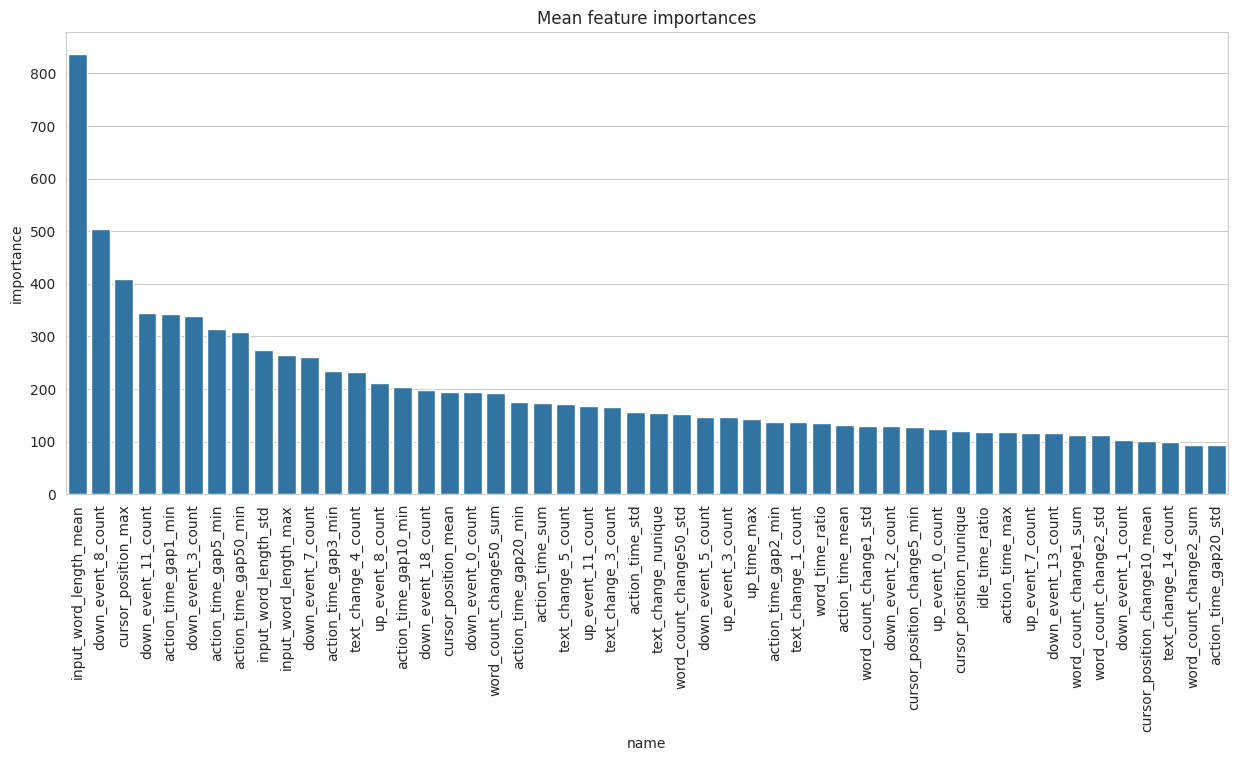

In [67]:
plt.figure(figsize=(15, 6))

ax = sns.barplot(data=feature_importance_df, x="name", y="importance")
ax.set_title(f"Mean feature importances")
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)

plt.show()

# Evaluation of OOF Preds on Training Set (CV)

In [68]:
for fold in range(CONFIG.num_folds):
    print(f"Predicting the train set with FOLD {fold}")
    X_train = train_feats[train_feats["fold"] != fold][feature_names]
    Y_train = train_feats[train_feats["fold"] != fold][CONFIG.response_variate]

    X_val = train_feats[train_feats["fold"] == fold][feature_names]
    Y_val = train_feats[train_feats["fold"] == fold][CONFIG.response_variate]

    lgb_model = models_dict[fold]
    pred_val = lgb_model.predict(
        X_val,
        num_iteration=lgb_model.best_iteration_,
    )
    train_feats.loc[X_val.index, f"pred_{CONFIG.response_variate}"] = pred_val
    print(f"{fold}, {lgb_model.best_iteration_}, {train_feats.shape}")

Predicting the train set with FOLD 0
0, 1578, (2471, 306)
Predicting the train set with FOLD 1
1, 1353, (2471, 306)
Predicting the train set with FOLD 2
2, 1039, (2471, 306)
Predicting the train set with FOLD 3
3, 1316, (2471, 306)
Predicting the train set with FOLD 4
4, 1803, (2471, 306)


In [69]:
train_feats.pred_score.describe()

count    2471.000000
mean        3.712978
std         0.799474
min         1.481061
25%         3.160504
50%         3.777231
75%         4.328851
max         5.348910
Name: pred_score, dtype: float64

In [70]:
train_feats.pred_score.describe()

count    2471.000000
mean        3.712978
std         0.799474
min         1.481061
25%         3.160504
50%         3.777231
75%         4.328851
max         5.348910
Name: pred_score, dtype: float64

In [71]:
train_feats.head()

,id,event_id_max,up_time_max,action_time_sum,action_time_max,action_time_mean,action_time_std,activity_nunique,down_event_nunique,up_event_nunique,text_change_nunique,cursor_position_nunique,cursor_position_max,cursor_position_mean,word_count_nunique,word_count_max,word_count_mean,action_time_gap1_max,action_time_gap1_min,action_time_gap1_mean,action_time_gap1_std,action_time_gap1_sum,cursor_position_change1_max,cursor_position_change1_min,cursor_position_change1_mean,cursor_position_change1_std,cursor_position_change1_sum,word_count_change1_max,word_count_change1_min,word_count_change1_mean,word_count_change1_std,word_count_change1_sum,action_time_gap2_max,action_time_gap2_min,action_time_gap2_mean,action_time_gap2_std,action_time_gap2_sum,cursor_position_change2_max,cursor_position_change2_min,cursor_position_change2_mean,cursor_position_change2_std,cursor_position_change2_sum,word_count_change2_max,word_count_change2_min,word_count_change2_mean,word_count_change2_std,word_count_change2_sum,action_time_gap3_max,action_time_gap3_min,action_time_gap3_mean,action_time_gap3_std,action_time_gap3_sum,cursor_position_change3_max,cursor_position_change3_min,cursor_position_change3_mean,cursor_position_change3_std,cursor_position_change3_sum,word_count_change3_max,word_count_change3_min,word_count_change3_mean,word_count_change3_std,word_count_change3_sum,action_time_gap5_max,action_time_gap5_min,action_time_gap5_mean,action_time_gap5_std,action_time_gap5_sum,cursor_position_change5_max,cursor_position_change5_min,cursor_position_change5_mean,cursor_position_change5_std,cursor_position_change5_sum,word_count_change5_max,word_count_change5_min,word_count_change5_mean,word_count_change5_std,word_count_change5_sum,action_time_gap10_max,action_time_gap10_min,action_time_gap10_mean,action_time_gap10_std,action_time_gap10_sum,cursor_position_change10_max,cursor_position_change10_min,cursor_position_change10_mean,cursor_position_change10_std,cursor_position_change10_sum,word_count_change10_max,word_count_change10_min,word_count_change10_mean,word_count_change10_std,word_count_change10_sum,action_time_gap20_max,action_time_gap20_min,action_time_gap20_mean,action_time_gap20_std,action_time_gap20_sum,cursor_position_change20_max,cursor_position_change20_min,cursor_position_change20_mean,cursor_position_change20_std,cursor_position_change20_sum,word_count_change20_max,word_count_change20_min,word_count_change20_mean,word_count_change20_std,word_count_change20_sum,action_time_gap50_max,action_time_gap50_min,action_time_gap50_mean,action_time_gap50_std,action_time_gap50_sum,cursor_position_change50_max,cursor_position_change50_min,cursor_position_change50_mean,cursor_position_change50_std,cursor_position_change50_sum,word_count_change50_max,word_count_change50_min,word_count_change50_mean,word_count_change50_std,word_count_change50_sum,activity_0_count,activity_1_count,activity_2_count,activity_3_count,activity_4_count,down_event_0_count,down_event_1_count,down_event_2_count,down_event_3_count,down_event_4_count,down_event_5_count,down_event_6_count,down_event_7_count,down_event_8_count,down_event_9_count,down_event_10_count,down_event_11_count,down_event_12_count,down_event_13_count,down_event_14_count,down_event_15_count,down_event_16_count,down_event_17_count,down_event_18_count,down_event_19_count,down_event_20_count,down_event_21_count,down_event_22_count,down_event_23_count,down_event_24_count,down_event_25_count,down_event_26_count,down_event_27_count,down_event_28_count,down_event_29_count,down_event_30_count,down_event_31_count,down_event_32_count,down_event_33_count,down_event_34_count,down_event_35_count,down_event_36_count,down_event_37_count,down_event_38_count,down_event_39_count,down_event_40_count,down_event_41_count,down_event_42_count,down_event_43_count,down_event_44_count,down_event_45_count,down_event_46_count,down_event_47_count,down_event_48_count,down_event_49_count,down_event_50_count,down_event_51_count,down_event_52_cou

In [72]:
np.clip(train_feats[f"pred_{CONFIG.response_variate}"], a_min=0.5, a_max=6.0).describe()

count    2471.000000
mean        3.712978
std         0.799474
min         1.481061
25%         3.160504
50%         3.777231
75%         4.328851
max         5.348910
Name: pred_score, dtype: float64

In [73]:
rmse = mean_squared_error(
    train_feats[CONFIG.response_variate].values,
    np.clip(train_feats[f"pred_{CONFIG.response_variate}"], a_min=0.5, a_max=6.0),
    # train_feats[f"pred_{CONFIG.response_variate}"].values,
    squared=False,
)
print("CV RMSE:", rmse)

CV RMSE: 0.6440107199767426


In [74]:
rmse = mean_squared_error(
    train_feats[CONFIG.response_variate].values,
    np.clip(train_feats[f"pred_{CONFIG.response_variate}"], a_min=0.5, a_max=6.0),
    # train_feats[f"pred_{CONFIG.response_variate}"].values,
    squared=False,
)
print("CV RMSE:", rmse)

CV RMSE: 0.6440107199767426


# Predicting The Test Set

We use the mean of all the predictions for all the fold models

In [42]:
for fold in range(CONFIG.num_folds):
    print(f"Predicting the test set with FOLD {fold}")
    X_test = test_feats[feature_names]

    lgb_model = models_dict[fold]
    pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration_)
    test_feats[f"pred_{CONFIG.response_variate}_fold{fold}"] = pred

test_feats[CONFIG.response_variate] = test_feats[
    [f"pred_{CONFIG.response_variate}_fold{fold}" for fold in range(CONFIG.num_folds)]
].mean(axis=1)
test_feats[CONFIG.response_variate] = np.clip(
    test_feats[CONFIG.response_variate], a_min=0.5, a_max=6.0
)

Predicting the test set with FOLD 0
Predicting the test set with FOLD 1
Predicting the test set with FOLD 2
Predicting the test set with FOLD 3
Predicting the test set with FOLD 4
Predicting the test set with FOLD 5
Predicting the test set with FOLD 6
Predicting the test set with FOLD 7
Predicting the test set with FOLD 8
Predicting the test set with FOLD 9


# Submission

In [43]:
submission = test_feats[["id", CONFIG.response_variate]]
submission

,id,score
0,0000aaaa,1.421791
1,2222bbbb,1.426217
2,4444cccc,1.425719


In [44]:
submission.to_csv("submission.csv", index=False)